In [15]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units
from bilby.gw.cosmology import z_at_value
from astropy.cosmology import FlatLambdaCDM

In [16]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Function Definitions

In [17]:
# Mass distributions
def mean(DL, dMdDL = 30./1000., offset = 5.):
    return DL*dMdDL + offset

def std(DL, dMdDL = 8./1000., offset = 1.):
    return DL*dMdDL + offset

def PLpeak(m, alpha = -2., mmin = 5., mmax = 70., mu = 30., sigma = 4., w = 0.2):
    norm_pl = (1-alpha)/(mmin**(alpha+1) - mmax**(alpha+1))
    pl      = norm_pl * m**alpha
    peak    = np.exp(-0.5*((m-mu)/sigma)**2)/(np.sqrt(2*np.pi)*sigma)
    return w*pl + (1-w)*peak

def evolving_gaussian(m, DL):
    mu = mean(DL)
    sigma = std(DL)
    return np.exp(-0.5*((m-mu)/sigma)**2)/(np.sqrt(2*np.pi)*sigma)

# DL distributions
def DLsq(DL, DLmax = 5000):
    return 3*DL**2/DLmax**3

def gaussian(DL, mu = 1600, sigma = 400):
    return np.exp(-0.5*((DL-mu)/sigma)**2)/(np.sqrt(2*np.pi)*sigma)

In [18]:
from figaro.cosmology import CosmologicalParameters
from figaro.load import _find_redshift

def luminosity_distance_to_redshift(distance, H0s):
    zs = []
    for H0 in H0s:
        Omega = CosmologicalParameters(H0/100, 0.315, 0.685, -1, 0)
        z = np.array([_find_redshift(Omega, d) for d in distance])
        zs.append(z)
    return np.array(zs)        

### Source Frame Distributions
Double Gaussian:
$$p(M, d_L) = p(M|d_L)p(d_L) = \mathrm{evolving\_gaussian}(M, d_L)*\mathrm{gaussian}(d_L)$$

Realistic Model:
$$p(M, d_L) = p(M)p(d_L) = \mathrm{PLpeak}(M)*\mathrm{DLsq}(d_L)$$

In [19]:
m = np.linspace(10,200,1000).reshape(-1,1)
dL = np.linspace(10,5000,100)

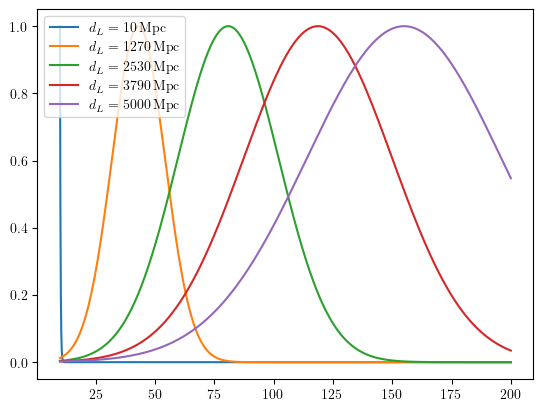

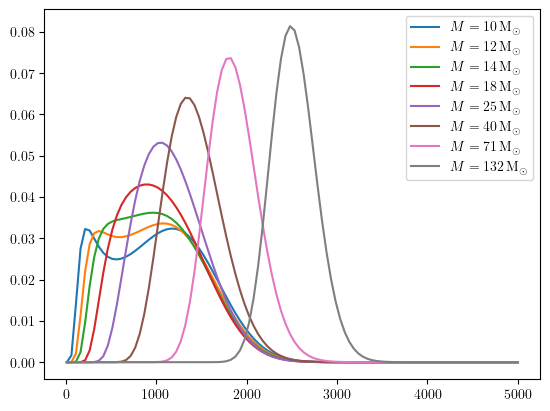

In [20]:
for i in [0,25,50,75,99]:
    prop = np.einsum("ij, j -> ij", evolving_gaussian(m, dL), gaussian(dL))[:,i]
    y = prop/np.max(prop)
    plt.plot(m, y, label = "$d_L = "+str(f'{dL[i]:.0f}')+"\,\mathrm{Mpc}$")
plt.legend()
plt.show()

for i in [0,10,20,40,80,160,320,640]:
    prop = np.einsum("ij, j -> ij", evolving_gaussian(m, dL), gaussian(dL))[i,:]
    y = prop/np.sum(prop)
    plt.plot(dL, y, label = "$M = "+str(f'{m[i,0]:.0f}')+"\,\mathrm{M}_\odot$")
plt.legend()
plt.show()

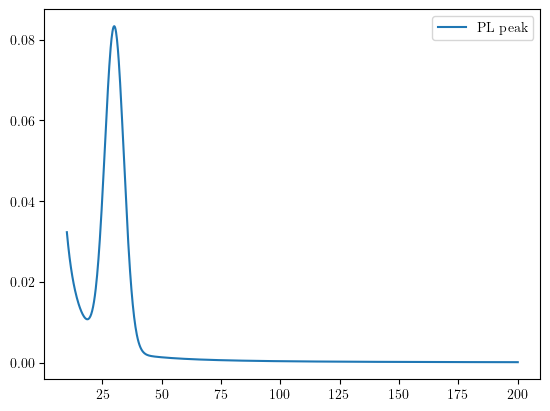

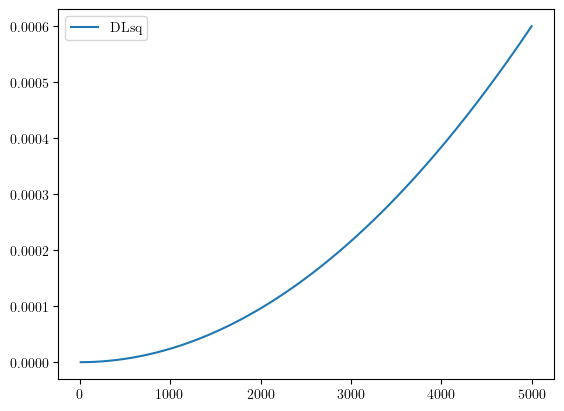

In [21]:
plt.plot(m, PLpeak(m), label = "PL peak")
plt.legend()
plt.show()
plt.plot(dL, DLsq(dL), label = "DLsq")
plt.legend()
plt.show()

### Detector Frame Distributions
Double Gaussian:
$$p(M_z, d_L) = \frac{1}{1+z(d_L, \Omega)}\,\mathrm{evolving\_gaussian}\left(\frac{M_z}{1+z(d_L, \Omega)}, d_L\right)\,\mathrm{gaussian}(d_L)$$

Realistic Model:
$$p(M_z, d_L) = \frac{1}{1+z(d_L, \Omega)}\,\mathrm{PLpeak}\left(\frac{M_z}{1+z(d_L, \Omega)}\right)\,\mathrm{DLsq}(d_L)$$

In [22]:
mz = np.linspace(10,200,1000)
dL = np.linspace(10,5000,100)

H0 = np.linspace(50,100,50)

z = luminosity_distance_to_redshift(dL, H0)

m = np.einsum("i, jk -> ikj", mz, np.reciprocal(1+z))

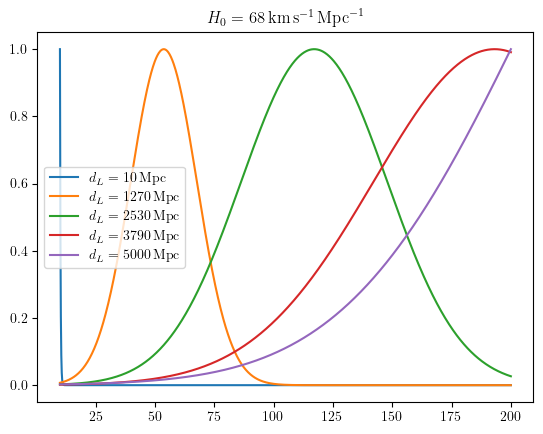

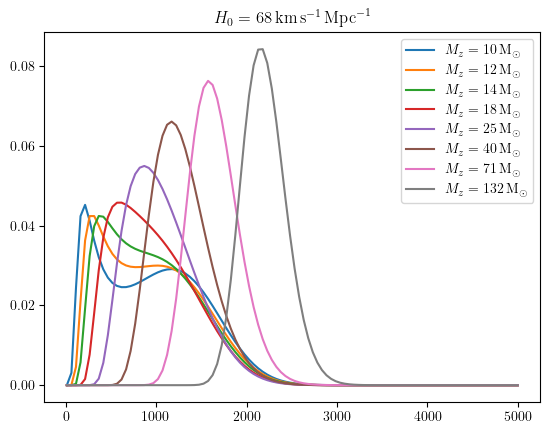

In [23]:
for i in [0,25,50,75,99]:
    prop = np.einsum("ijk, j -> ijk", evolving_gaussian(m, dL.reshape(-1,1)), gaussian(dL))[:,i,18]
    y = prop/np.max(prop)
    plt.plot(mz, y, label = "$d_L = "+str(f'{dL[i]:.0f}')+"\,\mathrm{Mpc}$")
plt.title("$H_0 = "+str(f'{H0[18]:.0f}')+"\,\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$")
plt.legend()
plt.show()

for i in [0,10,20,40,80,160,320,640]:
    prop = np.einsum("ijk, j -> ijk", evolving_gaussian(m, dL.reshape(-1,1)), gaussian(dL))[i,:,18]
    y = prop/np.sum(prop)
    plt.plot(dL, y, label = "$M_z = "+str(f'{mz[i]:.0f}')+"\,\mathrm{M}_\odot$")
plt.title("$H_0 = "+str(f'{H0[18]:.0f}')+"\,\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$")
plt.legend()
plt.show()

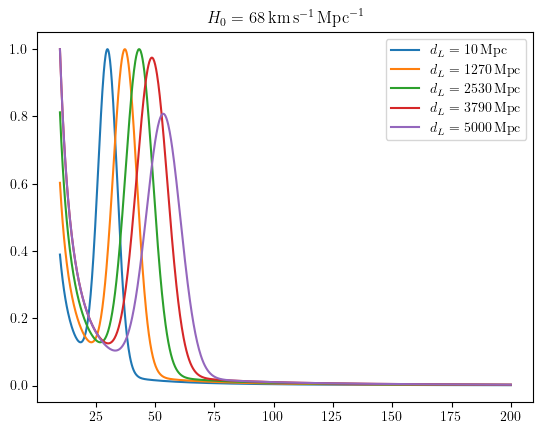

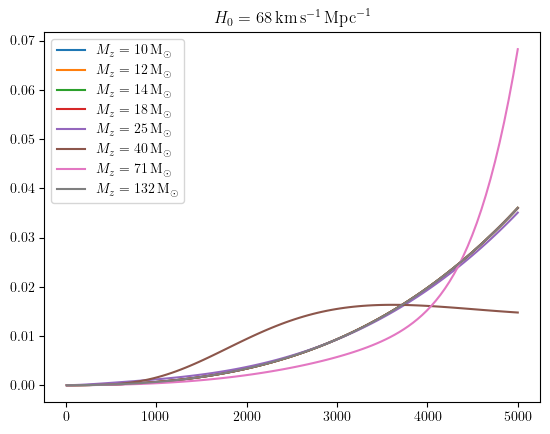

In [24]:
for i in [0,25,50,75,99]:
    prop = np.einsum("ijk, j -> ijk", PLpeak(m), DLsq(dL))[:,i,18]
    y = prop/np.max(prop)
    plt.plot(mz, y, label = "$d_L = "+str(f'{dL[i]:.0f}')+"\,\mathrm{Mpc}$")
plt.title("$H_0 = "+str(f'{H0[18]:.0f}')+"\,\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$")
plt.legend()
plt.show()

for i in [0,10,20,40,80,160,320,640]:
    prop = np.einsum("ijk, j -> ijk", PLpeak(m), DLsq(dL))[i,:,18]
    y = prop/np.sum(prop)
    plt.plot(dL, y, label = "$M_z = "+str(f'{mz[i]:.0f}')+"\,\mathrm{M}_\odot$")
plt.title("$H_0 = "+str(f'{H0[18]:.0f}')+"\,\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$")
plt.legend()
plt.show()

### Infer $H_0$

In [40]:
mz = np.linspace(10,200,1000)
dL = np.linspace(10,5000,100)

H0 = np.linspace(10,100,100)

z = luminosity_distance_to_redshift(dL, H0)

m = np.einsum("i, jk -> ikj", mz, np.reciprocal(1+z))

In [41]:
p_double_gaussian = np.trapz(np.einsum("ijk, j -> ijk", evolving_gaussian(m, dL.reshape(-1,1)), gaussian(dL)), dL, axis=1)
p_double_gaussian = p_double_gaussian/np.trapz(p_double_gaussian, mz, axis=0)

p_realistic = np.trapz(np.einsum("ijk, j -> ijk", PLpeak(m), DLsq(dL)), dL, axis=1)
p_realistic = p_realistic/np.trapz(p_realistic, mz, axis=0)

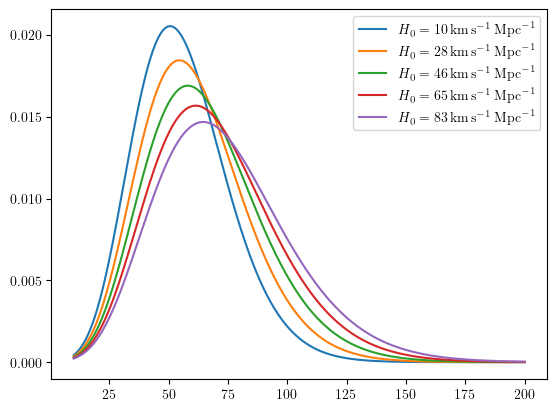

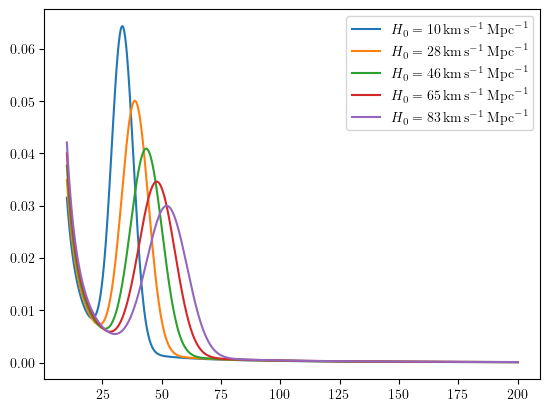

In [42]:
for i in [0,20,40,60,80]:
    prop = p_double_gaussian[:,i]
    plt.plot(mz, prop, label = "$H_0 = "+str(f'{H0[i]:.0f}')+"\,\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$")
plt.legend()
plt.show()
for i in [0,20,40,60,80]:
    prop = p_realistic[:,i]
    plt.plot(mz, prop, label = "$H_0 = "+str(f'{H0[i]:.0f}')+"\,\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$")
plt.legend()
plt.show()

In [43]:
double_gaussian_figaro = np.loadtxt("/Users/thomas.ng/Documents/GitHub/population_analysis/H0_test/double_gaussian/prob_density.txt")
realistic_figaro = np.loadtxt("/Users/thomas.ng/Documents/GitHub/population_analysis/H0_test/realistic/prob_density.txt")

In [44]:
double_gaussian_error = np.sum(np.square(p_double_gaussian - np.full((len(H0), len(mz)), np.interp(mz, double_gaussian_figaro[:,0], double_gaussian_figaro[:,1])).T), axis=0)
realistic_error = np.sum(np.square(p_realistic - np.full((len(H0), len(mz)), np.interp(mz, realistic_figaro[:,0], realistic_figaro[:,1])).T), axis=0)

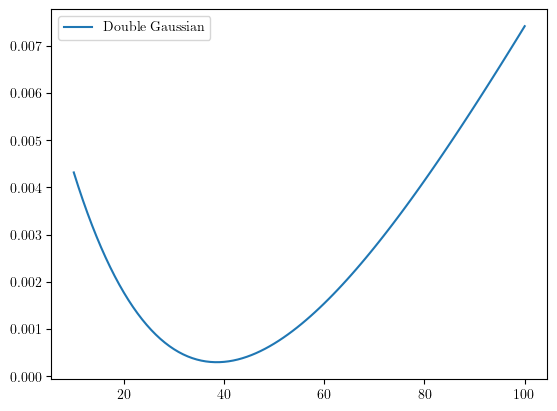

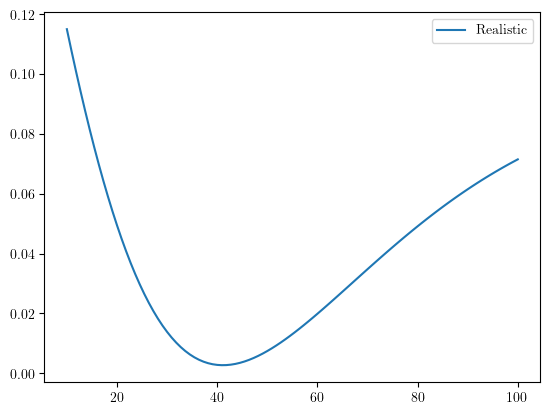

In [45]:
plt.plot(H0, double_gaussian_error, label = "Double Gaussian")
plt.legend()
plt.show()

plt.plot(H0, realistic_error, label = "Realistic")
plt.legend()
plt.show()

In [46]:
H0_double_gaussian = H0[np.argmin(double_gaussian_error)]
H0_realistic = H0[np.argmin(realistic_error)]

In [47]:
H0_double_gaussian, H0_realistic

(38.18181818181818, 40.90909090909091)